In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re

# Load data

## for barcode, feature, matrix file.

In [2]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [3]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
adata_list = read_10x_mtx_multiple(folder_path)

adata_list
# 40s for 24 samples
# 1m 39s for 104 samples

C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\GSM7507506_Pt1_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507506_Pt1_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507506_Pt1_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\GSM7507507_Pt2_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507507_Pt2_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507507_Pt2_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\GSM7507508_Pt3_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507508_Pt3_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\\GSM7507508_Pt3_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc\GSM7507509_Pt4_matrix.mtx.g

[AnnData object with n_obs × n_vars = 2896 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 670 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1576 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2524 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7315 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2851 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1566 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7594 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 12617 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object wit

In [4]:
len(adata_list)

24

# C10orf54와 VSIR의 count 합치기
많은 CX?\d*orf\d 유전자가 있음.

In [8]:
old_gene_name = 'C10orf54'
new_gene_name = 'VSIR'

# 'C10orf54'가 존재하고 'VSIR'이 존재하지 않을 때 gene name 변경
for adata in adata_list:
    if old_gene_name in adata.var_names and new_gene_name not in adata.var_names:
        adata.var_names = np.where(adata.var_names == old_gene_name, new_gene_name, adata.var_names)
    

# Basic filtering

In [22]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 200)
adata_list

[AnnData object with n_obs × n_vars = 2887 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 644 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1545 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2456 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7019 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2773 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1556 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7315 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 126

# n_count_RNa, n_count_feature, pct_mt filtering

In [23]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [24]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [25]:
adata_list[1].obs.head(5)

,sample,n_genes,n_genes_by_counts,total_counts,pct_counts_mito,pct_counts_ribo
AAACCCAGTCTGTGTA-1,Pt2,2190,2190,6393.0,11.512591,12.779602
AAACGAATCGGAGTGA-1,Pt2,5393,5393,20278.0,3.994477,8.274978
AAACGCTGTTAATCGC-1,Pt2,3426,3426,22395.0,6.742577,23.621346
AAAGGTAAGCCGTCGT-1,Pt2,558,558,1171.0,38.855679,7.856533
AAAGTCCAGGATCATA-1,Pt2,3231,3231,14595.0,0.979788,26.036314


In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [26]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [27]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

24

In [28]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 522.


# Doublet removal
> **scVI SOLO와 Scrublet 두 방식 <- 둘 중 하나만 쓰면 됨**

## By scVI SOLO
> (아마) 좋은거 같긴 한데 개느림\
> 아래 코드 돌아가는지도 잘 모르겠음. 돌리는데 오래걸려서 체크 안함\

In [ ]:
# import torch

# check if the GPU is available
# torch.cuda.get_device_name(0)

In [ ]:
import scvi

# doublet detection function using scvi and solo models
def doublet_detection(adata):
    # train the scvi model
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    
    # train the solo model
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    
    # predict the doublet score
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    # df.index = df.index.map(lambda x: x[:-2])                         # not required if use adata.copy()
    df['dif'] = df.doublet - df.singlet
    
    return adata, df

In [ ]:
# doublet detection
for i in range(len(adata_list)):
    adata_list[i], df = doublet_detection(adata_list[i].copy())                 # doublet detection
    print(df.groupby('prediction').count())                             # print the number of predicted doublets and singlets
    
    sns.displot(df[df.prediction == 'doublet'], x = 'dif')              # plot the doublet score distribution
    
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]          # df.dif cutoff는 적당히 설정
    adata_list[i].obs['doublet'] = adata_list[i].obs.index.isin(doublets.index) # add the doublet information to the obs
    
    adata_list[i] = adata_list[i][~adata_list[i].obs.doublet]                       # remove the doublets from the data
    
# ~6.25 min per sample

## By Scrublet 
> 빨라서 씀. SOLO보다 doublet을 더 적게 detection함\
> 약 37k cells 돌리는데 16초\
> 제대로 되는건 맞는지 잘 모름

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


c:\Users\heung\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.1%
Elapsed time: 1.4 seconds
Processed adata 1/24 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 19.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 0.3 seconds
Processed adata 2/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 0.5 seconds
Processed adata 3/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 9.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 1.0 seconds
Processed adata 4/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 23.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.3%
Elapsed time: 8.5 seconds
Processed adata 5/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 8.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 1.1 seconds
Processed adata 6/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 42.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 0.4 seconds
Processed adata 7/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 53.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 6.9 seconds
Processed adata 8/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.3%
Elapsed time: 5.2 seconds
Processed adata 9/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 1.0 seconds
Processed adata 10/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.3%
Elapsed time: 4.7 seconds
Processed adata 11/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 7.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 0.6 seconds
Processed adata 12/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.4 seconds
Processed adata 13/24 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.0 seconds
Processed adata 14/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 36.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.2%
Elapsed time: 8.8 seconds
Processed adata 15/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.8 seconds


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Processed adata 16/24 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 20.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.9%
Elapsed time: 12.2 seconds
Processed adata 17/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 36.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.4%
Elapsed time: 12.0 seconds
Processed adata 18/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 9.3 seconds
Processed adata 19/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.1%
Elapsed time: 6.6 seconds
Processed adata 20/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.1%
Elapsed time: 15.1 seconds
Processed adata 21/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\scrublet.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = fig_size)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 16.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.2%
Elapsed time: 13.3 seconds
Processed adata 22/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 32.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 16.4 seconds
Processed adata 23/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.7%
Elapsed time: 33.5 seconds
Processed adata 24/24 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_45760\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


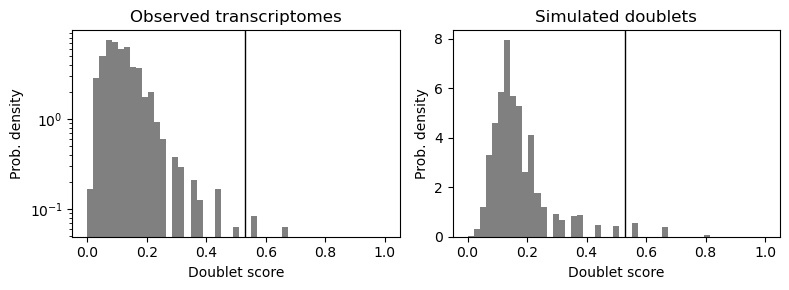

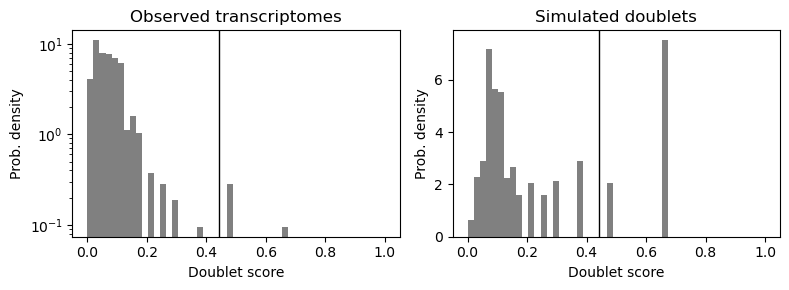

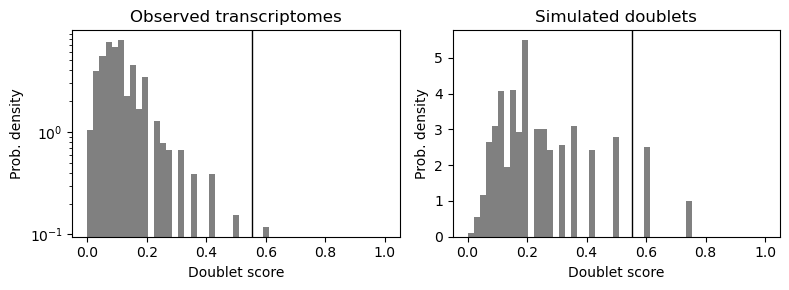

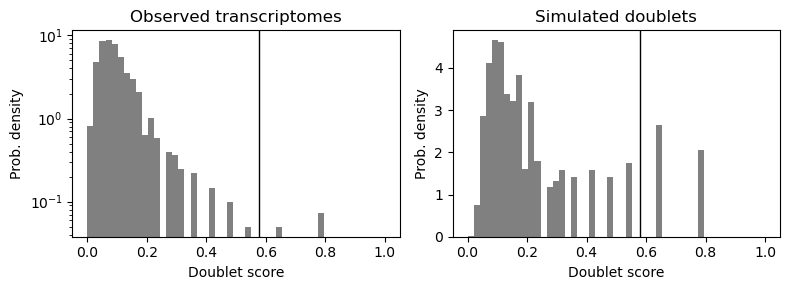

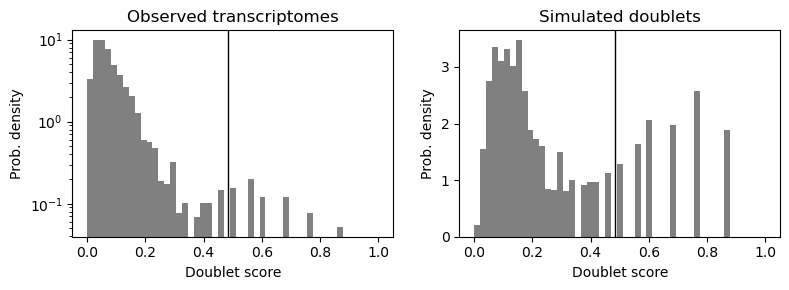

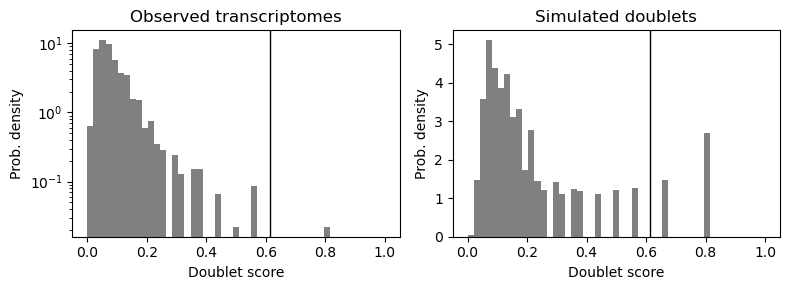

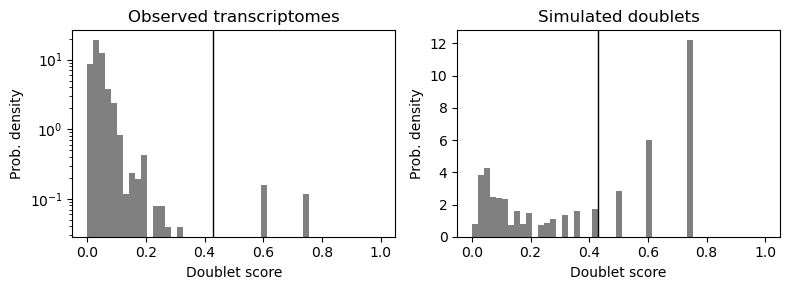

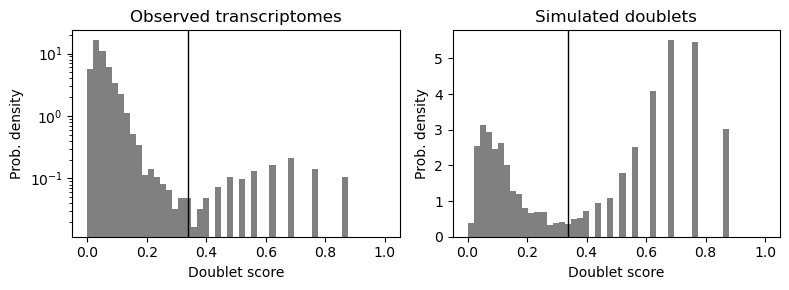

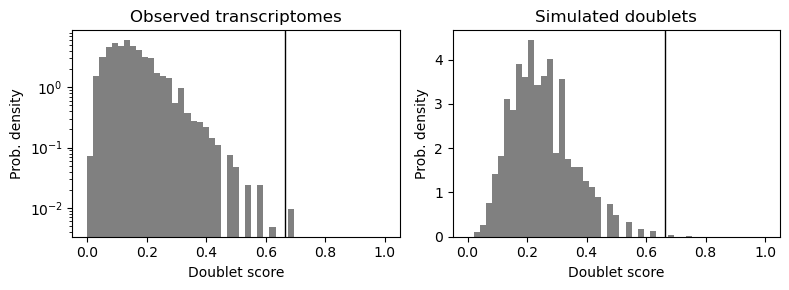

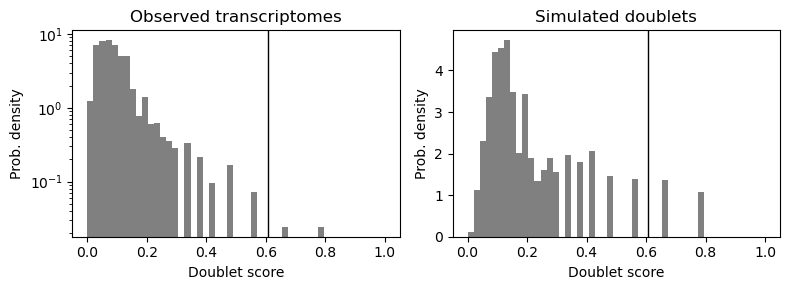

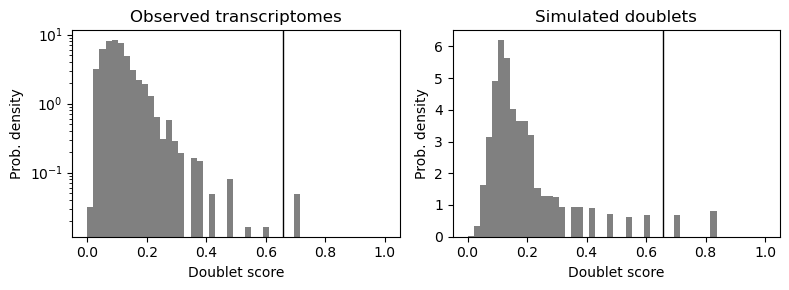

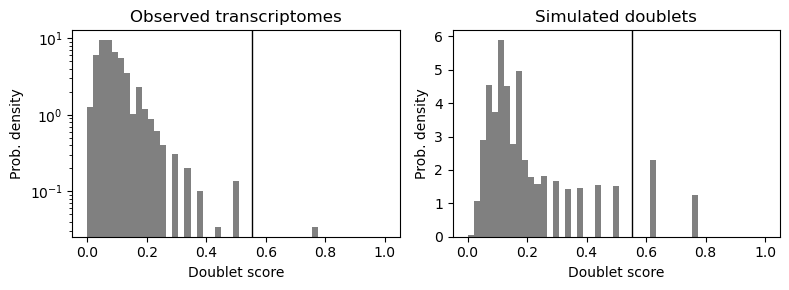

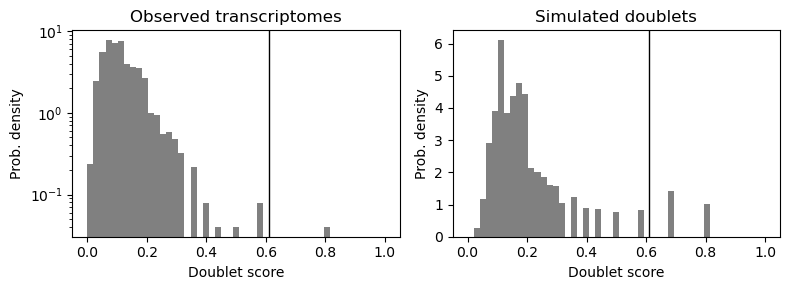

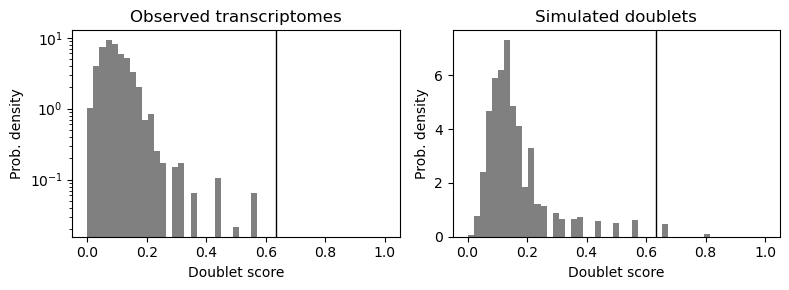

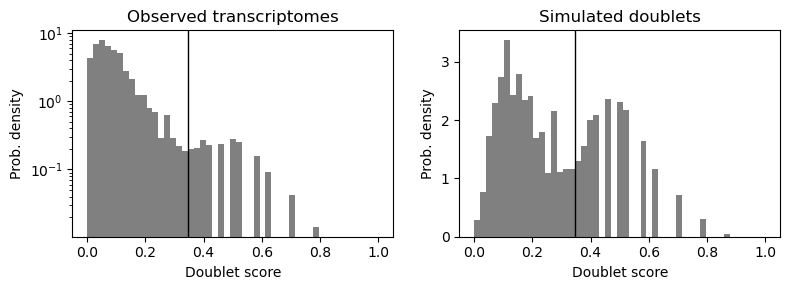

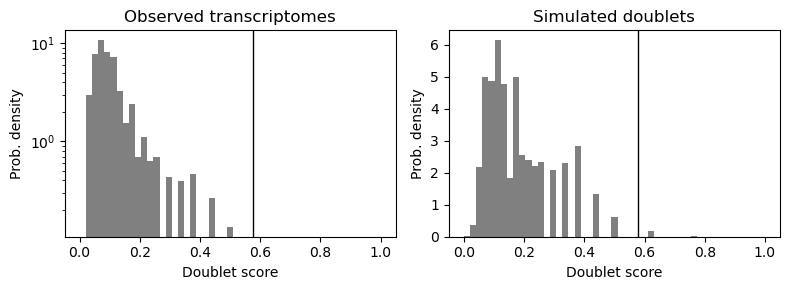

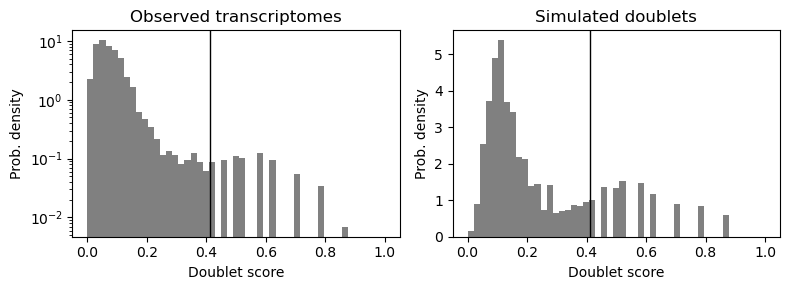

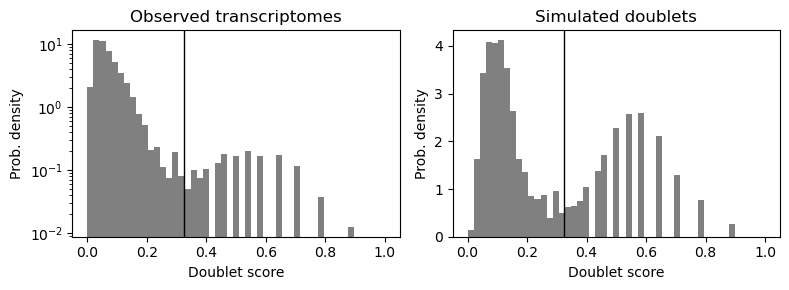

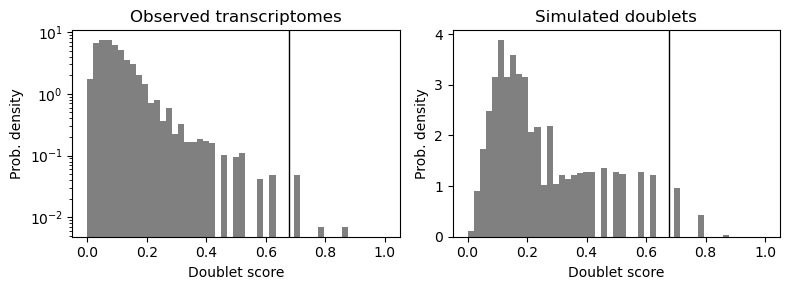

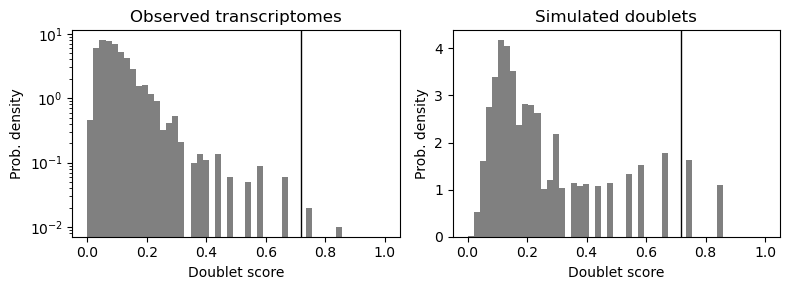

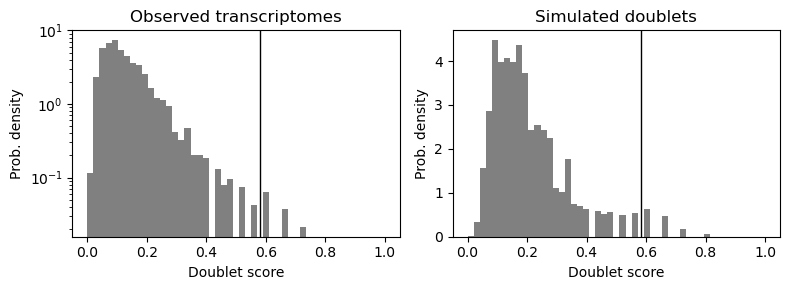

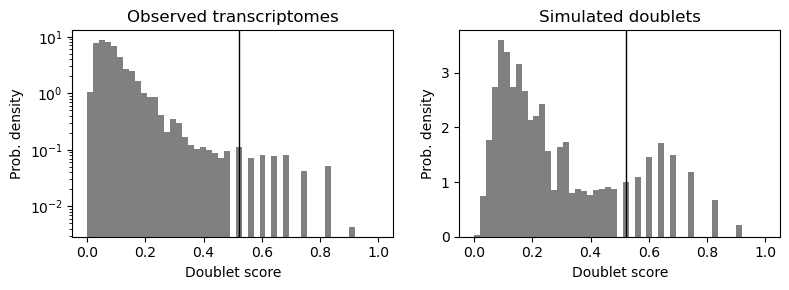

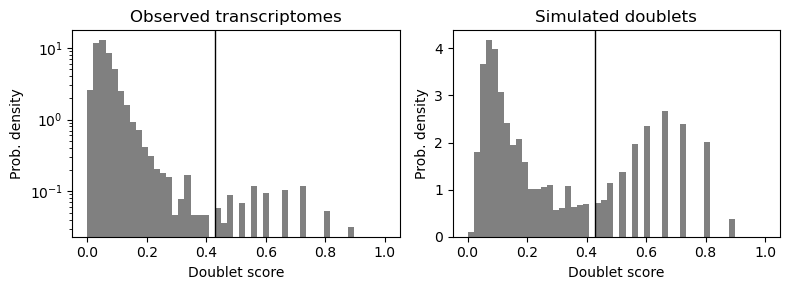

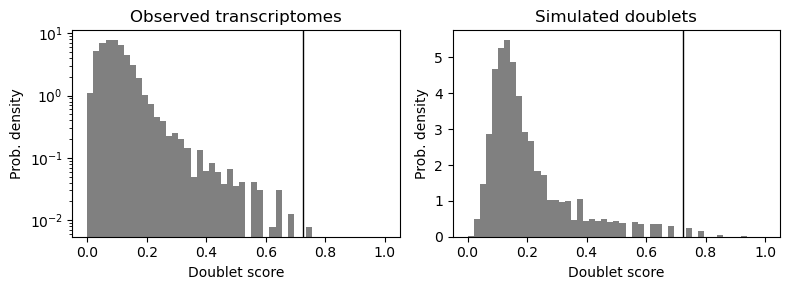

In [29]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets
# 3m 36s for 24 samples
# 2m 47s for 24 samples
# 1m 24.9s for Normalized, log scaled 24 samples

# 4m 48s for 95 samples ~250k cells

In [30]:
# visualize and FILTER the doublets <- 돌려야 함.
for i in range(len(adata_list)):
    # visualize the doublets
    # sc.pp.pca(adata_list[i])
    # sc.pp.neighbors(adata_list[i])
    # sc.tl.umap(adata_list[i])
    # sc.pl.umap(adata_list[i], color=['doublet_scores', 'predicted_doublets'])
    
    # filter the doublets
    try:
        adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    except Exception as e:
        continue
del i

In [31]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

24

In [32]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 518.


# Normalization and log scale the data
> Scrublet으로 doublet 제거하기 전에 하면 Pt23 샘플에서 오류남. 이유는 모르고 predicted_doublet에 None이 저장됨.

In [33]:
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum = 1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  vi

# Merge the data

In [34]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Save the merged adata

In [36]:

adata.write_h5ad(folder_path + '\\adata_preprocessed.h5ad')